# Sparse Sheaf Signal Processing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm
from vdm import VDM

### Synthetic Data

##### Point Cloud in a Cube

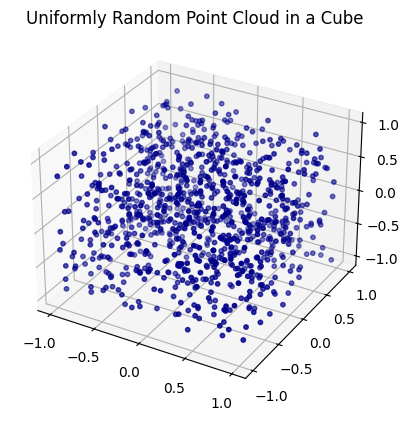

In [2]:
# Generate a cube in R^3 with uniformly random points
N = 1000 # number of points in the cloud
np.random.seed(6111983)
cube_point_cloud = np.random.uniform(-1,1,N*3).reshape((N, 3)) # points
# Plot the cube
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(cube_point_cloud[:,0], cube_point_cloud[:,1], cube_point_cloud[:,2], marker='o', s=10, c='darkblue')
plt.title('Uniformly Random Point Cloud in a Cube')
plt.show()

##### Random points on a Sphere in R^3

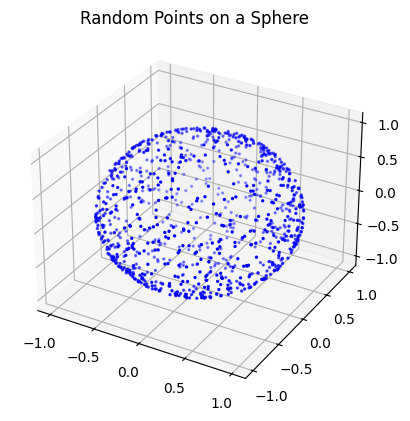

In [14]:
# Sphere with random points
N = 1000 # number of points
np.random.seed(6111983)
sphere_points = np.random.randn(N,3) # points
sphere_points /= np.linalg.norm(sphere_points, axis=1, keepdims=True) # normalize
# Plot the points
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(sphere_points[:,0], sphere_points[:,1], sphere_points[:,2], marker='o', s=2, c='blue')
plt.title('Random Points on a Sphere')
plt.show()

### Using the VDM class

##### Hyperparameters and Data

In [4]:
x = sphere_points  # DATA: cube_point_cloud or sphere_points
eps = 0.15 # epsilon for the graph
eps_pca = 0.1 # epsilon for the local PCA
k = 30 # number of neighbors
gamma = 0.95 # information variability threshold in dimension estimation with singular values

##### Graph Creation

In [5]:
# Create the vdm object
vdm = VDM(x, eps, eps_pca, k, gamma=0.95)

In [6]:
# Create the graph
G = vdm.make_graph()

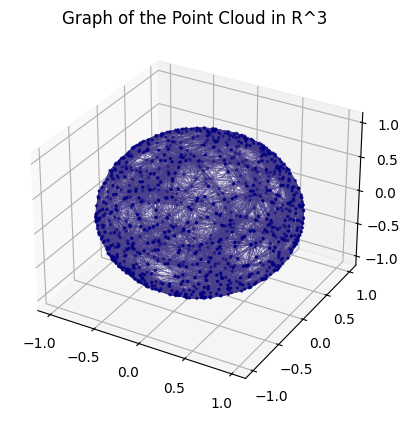

In [8]:
# Plot the points
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x[:,0], x[:,1], x[:,2], marker='o', s=2, c='navy')
# Plot the edges
for edge in G.edges():
    x1, y1, z1 = x[edge[0]]
    x2, y2, z2 = x[edge[1]]
    ax.plot([x1, x2], [y1, y2], [z1, z2], c='darkslateblue', linewidth=0.5, alpha=0.5)
plt.title('Graph of the Point Cloud in R^3')
plt.show()

##### Orthonormal Basis Approximation

In [7]:
# Approximate the orthonormal bases of the tangent vector spaces at every point
# Returns a list of orthonormal bases, with O[i] = O_i (orthonormal basis of the tangent vector space of node i)
O = vdm.make_orthonormal_bases()
O[:3] # First three orthonormal bases (for nodes 1,2,3)

[array([[-0.97819392, -0.19212153],
        [ 0.07616353, -0.68526252],
        [-0.19322465,  0.70249883]]),
 array([[ 0.14251749,  0.46678034],
        [ 0.00799336,  0.88124414],
        [-0.98976001,  0.0743296 ]]),
 array([[-0.26133887,  0.9414852 ],
        [-0.85656642, -0.32786151],
        [-0.44496737,  0.07818209]])]

##### Alignment

In [8]:
# Compute the alignment matrices
# O_alignment is a dictionary of dictionaries with O_alignment[i][j] = O_ij = U V^T
# with U @ Sigma @ V.T singular value decomposition of O_i.T @ O_j
O_alignment = vdm.make_alignment_matrices()
O_alignment[0][432] # Alignment matrix between node 0 and node 432

array([[ 0.67031742,  0.7420745 ],
       [-0.7420745 ,  0.67031742]])

##### Vector Diffusion Mapping

In [9]:
# Compute the diffusion distance between points 0 and 432 at time t=1
print(vdm.diffusion_distance(0,432,1))

0.9242956708563063


In [10]:
# Compute the diffusion map of point 3 at time 5   (V_t(i) for i=3, t=5)
print(vdm.vector_diffusion_mapping(3,5,p=1))
# p is the percentage of the vector that is computed because computing the whole vector might be infeasible for large N

[ 7.30849340e-06  7.04634138e-19  2.19646743e-05 ...  5.90975496e-11
 -4.47038792e-24  6.17704613e-11]


In [11]:
# Compute the vdm distance between points 0 and 432 at time t=1
print(vdm.vdm_distance(0,432,1))

0.04540595644891761


In [12]:
vector_dd = vdm.vdm_distance(0,1,1,p=0.8) # vdm distance between points 0 and 1 at time 1
print(vector_dd)
vector_dd2 = vdm.vdm_distance(0,432,1,p=0.8) # vdm distance between points 0 and 432 at time 1
print(vector_dd2)
print(np.linalg.norm(x[0]-x[1]))  # Euclidean distance between points 0 and 1
print(np.linalg.norm(x[0]-x[432]))  # Euclidean distance between points 0 and 432

0.052239470233577424
0.04540595644891761
1.6332140392597523
0.21312068649182153


In [13]:
normalized_vdm_dist = vdm.norm_vdm_distance(0,432,1,p=0.8) # normalized vdm distance between points 0 and 432 at time 1

##### Some Other Class Methods

In [15]:
d = vdm.estimate_dim() # Estimated dimension
W = vdm.get_weight_matrix() # Weight matrix
degrees = vdm.get_degree_vector() # Degree vector
S = vdm.get_alignment_block_matrix() # block matrix (S) formed by the weighted alignment matrices and zero blocks: dN x dN
D = vdm.get_kron_degree_matrix() # degree matrix (D): dN x dN with D(i,i) = deg(i) * I_{d x d}
D_cursive = vdm.get_degree_matrix() # degree matrix (D): N x N with D(i,i) = deg(i)
A = vdm.get_transition_matrix() # transition matrix (A): N x N with A = D_cursive^-1 W
S_tilde = vdm.get_affinity_matrix() # affinity matrix (S_tilde): dN x dN

##### Connection Laplacian of the Graph

In [ ]:
# Connection Laplacian of the graph, computed as D^-1 @ S - I
L = vdm.connection_laplacian()
# Compute eigenvalues and eigenvectors
eigvals, eigvecs = np.linalg.eig(L)
idx = np.argsort(eigvals)[::-1]  # ascending
eigvals = eigvals[idx]
eigvecs = eigvecs[:,idx]
eigvals

array([-0.03033506+0.j, -0.03033506+0.j, -0.03418989+0.j, ...,
       -1.2780625 +0.j, -1.28281861+0.j, -1.28281861+0.j], shape=(2000,))